<a href="https://colab.research.google.com/github/nguyen084/MATH5671/blob/master/group_005_assignment_005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machine Template for Credit Card Applications

In [122]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [123]:
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

os.chdir(r'/content/gdrive/My Drive/Academic/UCONN/Financial Research/MATH5671/')
credit_X_df = pd.read_csv("training_features.csv",header =0)
credit_X_df.head()

,checkin_acc,duration,credit_history,purpose,amount,saving_acc,present_emp_since,inst_rate,personal_status,other_debtors,residing_since,property,age,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker
0,A12,24,A34,A410,11938,A61,A73,2,A93,A102,3,A123,39,A143,A152,2,A174,2,A192,A201
1,A14,36,A32,A46,1819,A61,A73,4,A93,A101,4,A124,37,A142,A153,1,A173,1,A192,A201
2,A11,15,A34,A42,1478,A61,A75,4,A93,A101,4,A123,44,A143,A152,2,A173,2,A192,A201
3,A14,24,A34,A43,1516,A64,A73,4,A92,A101,1,A121,43,A143,A152,2,A172,1,A191,A201
4,A11,9,A32,A42,2136,A61,A73,3,A93,A101,2,A121,25,A143,A152,1,A173,1,A191,A201


In [124]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

credit_y_df = pd.read_csv("training_labels.csv",header =0)

# target variable distribution
credit_y_df.groupby(['status'])[['status']].count()

,status
status,
-1,214
1,486


It can be seen that the class distribution is unbalanced

In [125]:
credit_all_df = pd.concat([credit_X_df.reset_index(drop=True), credit_y_df], axis=1) 
credit_all_df.head()

,checkin_acc,duration,credit_history,purpose,amount,saving_acc,present_emp_since,inst_rate,personal_status,other_debtors,residing_since,property,age,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker,status
0,A12,24,A34,A410,11938,A61,A73,2,A93,A102,3,A123,39,A143,A152,2,A174,2,A192,A201,-1
1,A14,36,A32,A46,1819,A61,A73,4,A93,A101,4,A124,37,A142,A153,1,A173,1,A192,A201,-1
2,A11,15,A34,A42,1478,A61,A75,4,A93,A101,4,A123,44,A143,A152,2,A173,2,A192,A201,1
3,A14,24,A34,A43,1516,A64,A73,4,A92,A101,1,A121,43,A143,A152,2,A172,1,A191,A201,1
4,A11,9,A32,A42,2136,A61,A73,3,A93,A101,2,A121,25,A143,A152,1,A173,1,A191,A201,1


## Data Exploration
Exploring the dataset using plots, histograms, descriptive statistics, etc.

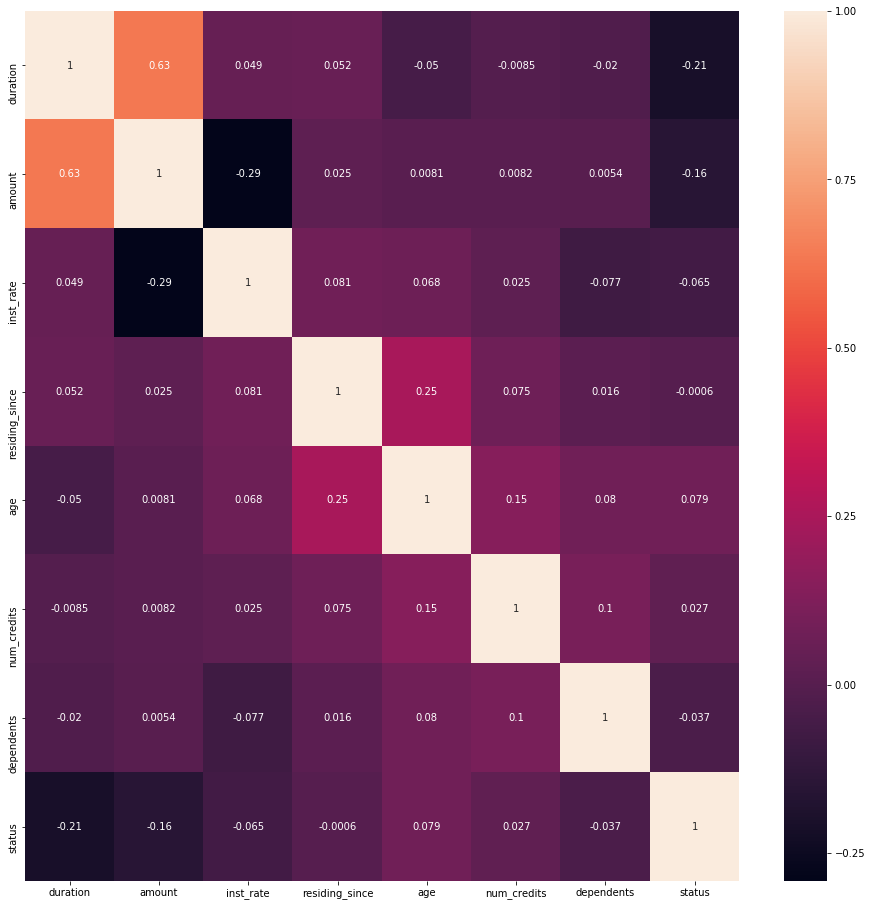

In [128]:
# just numeric variables
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = credit_all_df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr,annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Preprocessing
Convert a number of categorical variables to dummy variables

In [129]:
# convert categorical variables to dummy variables
cat_vars=['checkin_acc','credit_history','purpose','saving_acc','present_emp_since','personal_status','other_debtors',
          'property', 'inst_plans','housing','job', 'telephone', 'foreign_worker']

credit_X_df = pd.get_dummies(credit_X_df, columns = cat_vars)
credit_X_df.head()

KeyError: ignored

Data is unbalanced, undersampling or oversampling

In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(credit_X_df, credit_y_df, test_size=0.3, random_state=0)
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_sample(X_train, y_train)
X_resampled, y_resampled = shuffle(X_resampled, y_resampled)

Simple feature selection using correlation threshold

In [131]:
from scipy.stats.stats import pearsonr
relevant_features = []
for i in range(len(X_resampled[0]) - 1): 
    thres = 0.1
    corr = pearsonr(y_resampled.flatten(),X_resampled[:,i])[0]
        
    if abs(corr) > thres:
        relevant_features.append(i)
    
relevant_features

[0, 7, 8, 10, 11, 12, 15, 17, 20, 21, 26, 29, 30, 32, 43, 50, 57, 58]

In [0]:
X_resampled = X_resampled[:,relevant_features]

In [0]:
X_test = X_test.iloc[:,relevant_features]

Normalization

In [0]:
from sklearn.preprocessing import normalize
X_resampled = normalize(X_resampled)
X_test = normalize(X_test)

Use solve.qp to solve for alpha (which is x in the optimization problems)

![image.png](attachment:image.png)

In [0]:
import csv
import numpy as np
import math
import cvxopt as opt
from cvxopt import matrix, solvers

def kernel(XTest, XTrain, Ktype = 0, sigma = 0,c=0,d=1):
    # Write your code here to return the kernel, type may be 0, 1, 2 for different kernel types
    if Ktype == 0: #linear
      K = np.dot(XTest, XTrain.T) 
    if Ktype == 1:
      K = np.dot(XTest, XTrain.T+c)**d
    if Ktype == 2:
      Val_test = np.sum(XTest**2, axis = 1) #get the total variance of Xtest
      Val_train = np.sum(XTrain**2, axis = 1) #get the total variance of Xtrain
      product = np.dot(np.ones(np.size(XTest, axis=0))[:, None], Val_train.T[None,:]) - 2 * np.dot(XTest, XTrain.T)
      K = np.dot(Val_test[:,None], np.ones(np.size(XTrain, axis=0)).T[None,:]) + product
      K = np.exp(-K/(2*sigma))
    return K   

def predict(XTest, XTrain, yTrain, alpha, Type = 0, d = 1, sigma = 1):
    b = intercept(XTest, XTrain, yTrain, alpha, Type, d, sigma)
    K = kernel(XTest, XTrain, Type, d, sigma)
    pred = (K @ (alpha * yTrain) + b)
    pred[pred >= 0] = 1
    pred[pred < 0] = -1
    return pred

def intercept(XTest,XTrain, yTrain, alpha, Type = 0, d = 1, sigma = 1):
  return np.mean(yTrain - np.dot(kernel(XTrain, XTrain, Type, d, sigma), (np.multiply(alpha, yTrain))))

In [139]:
# Gaussian Kernel
TrainSize = X_resampled.shape[0]
K = kernel(X_resampled, X_resampled,Ktype = 2, sigma = 5)
a0 = np.random.randn(TrainSize)

# Inequality that individual alpha>=0
G = matrix(np.eye(TrainSize))
h = matrix(np.zeros(TrainSize))

# Equality that sum(alpha_i*y_i)=0
A = opt.matrix(np.double(y_resampled))
b = matrix(0.0)

# Change from min to max optimization by multiplying with -1
# Regularization term to force H positive definite
ymat = np.diag(y_resampled.flatten())
P = 0.5 * np.dot(ymat, np.dot(K, ymat)) + 1e-10 * np.identity(TrainSize)
q = opt.matrix(-np.ones((TrainSize,1)))

opts = {'maxiters':100000}
solvers.options['show_progress'] = False 
sol = solvers.qp(matrix(P), q, G, h, A.T, b, initvals = a0, options=opts) # solvers.qp to solve the optimization
alpha = np.array(sol['x'])
#alpha = preprocessing.scale(alpha)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  3e+02  2e+01  0e+00
 1:  0.0000e+00 -4.4409e-16  3e+00  2e-01  1e-16
 2:  1.8174e-16  2.7756e-17  3e-02  2e-03  1e-16
 3:  1.0059e-18  5.4210e-20  3e-04  2e-05  0e+00
 4:  9.6541e-21 -4.2352e-22  3e-06  2e-07  0e+00
 5:  1.0894e-22 -9.9262e-24  3e-08  2e-09  1e-16
Optimal solution found.


In [140]:
from sklearn import metrics
pred = predict(X_test, X_resampled, y_resampled, alpha, Type=2, sigma=5)
print('\nTraining Accuracy: '+ str(np.mean((pred == y_test) * 100)))
print("Accuracy:",metrics.accuracy_score(y_test, pred))
print("Precision:",metrics.precision_score(y_test, pred))
print("Recall:",metrics.recall_score(y_test, pred))
print("Confusion Matrix:\n")
print(metrics.confusion_matrix(y_test, pred))


Training Accuracy: status    66.666667
dtype: float64
Accuracy: 0.6666666666666666
Precision: 0.6763285024154589
Recall: 0.9790209790209791
Confusion Matrix:

[[  0  67]
 [  3 140]]


# Additional Model Scoring

Use your model to score the test dataset in the German Credit Card Application project/contest below. After joining, you can create a team and invite members. Submit your score result to see how it is ranked, and share your write-up/notebook
http://www.scriptedin.com/contests/view/20

(You need to convert categorical variables to dummy variables). You can re-train the model using the training dataset as well if you’d like.

In [141]:
test_feature_df = pd.read_csv("test_features.csv",header =0)
#test_feature_df = pd.get_dummies(test_feature_df, columns = cat_vars)
test_feature_df.head()

,STATE,REGION,SEX,PROFESSION,AGE,HAS_CHILDREN,SALARY,N_OF_DEPENDENTS,CAR_OWNERSHIP,HOUSE_OWNERSHIP,TIME_AS_CUSTOMER,MARITAL_STATUS,CREDIT_BALANCE,BANK_FUNDS,CHECKING_AMOUNT,MONEY_MONTLY_OVERDRAWN,T_AMOUNT_AUTOM_PAYMENTS,MONTHLY_CHECKS_WRITTEN,MORTGAGE_AMOUNT,N_TRANS_ATM,N_MORTGAGES,N_TRANS_TELLER,CREDIT_CARD_LIMITS,N_TRANS_KIOSK,N_TRANS_WEB_BANK,LTV,LTV_BIN
0,IL,Midwest,F,Bank Teller,21,1,69868,5,1,1,5,MARRIED,0,0,25,53.06,0,0,1500,0,1,0,1000,1,1500,17067.00,MEDIUM
1,CA,West,F,Truck Driver,50,0,71214,1,1,1,1,MARRIED,0,450,170,53.20,1159,18,1000,3,1,2,1000,1,1000,31303.50,VERY HIGH
2,FL,South,F,IT Staff,65,1,66389,3,1,1,4,DIVORCED,0,3200,25,55.41,2826,2,4000,5,1,2,800,8,400,24097.25,HIGH
3,IL,Midwest,M,Cashier,42,1,66473,1,1,1,1,DIVORCED,0,2950,25,53.45,1364,4,3737,4,1,1,2000,1,550,24318.25,HIGH
4,CA,West,M,Programmer/Developer,27,0,59710,3,1,0,3,SINGLE,0,700,25,53.22,268,9,0,3,0,3,1000,1,0,13127.50,LOW


In [0]:
# test_feature_df should have same columns as credit_X_df
test_feature_df = test_feature_df.reindex(columns = credit_X_df.columns, fill_value=0)

In [0]:
test_feature_df = test_feature_df.iloc[:,relevant_features]

In [144]:
test_feature_df = normalize(test_feature_df)
print(test_feature_df)
y_test_more_pred = predict(test_feature_df, X_resampled, y_resampled, alpha)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
y_test_more_pred= pd.DataFrame(y_test_more_pred)
y_test_more_pred= y_test_more_pred.reset_index()

In [146]:
y_test_more_pred.head()

,index,0
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


In [147]:
y_test_more_pred.columns = ['num','label']
y_test_more_pred.head()

,num,label
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0


In [0]:
y_test_more_pred['num'] = y_test_more_pred['num'] + 1
y_test_more_pred.to_csv(r'test_submission.csv', index = False)